In [5]:
import math
import re
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
OUTPUT_DIR="../data"
SCHOOL="stanford"
SUBJECT="opinions"
START_YEAR=2010
FINAL_YEAR=2022

In [7]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(a, b):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    # Calculate dot product and magnitudes of the input arrays
    dot = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    # Calculate and return the cosine distance
    return 1 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [9]:
diversity_pattern = "\b" + "|".join(diversity_lemmas) + "\b"
text = "This is an inclusive and multi-cultural center that focuses on equality and racial justice."
len(re.findall(diversity_pattern, text))

4

In [10]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    '''Clean & prep text (numpy.Series): lowercase, lemmatize, stopword'''
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split() 
                           if w not in english_stopwords))
    total_diversity_words = sum([len(re.findall(diversity_pattern, text)) 
                                 for text in text_series])
    return text_series, total_diversity_words

In [11]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    df = pd.read_parquet(f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-{year}.parquet")

    df['body_prepped'], num_diversity_words = prepText(df.body)
    wv = [nlp(s) for s in df['body_prepped']]
    docmatrix = np.array([v.vector for v in wv])
    
    cov = getCovDispersion(docmatrix)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2], 
              'norm-2':   cov[3], 
              'norm-inf': cov[4], 
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
              }
    results.append(result)
    print(f"{year}, {cov[0]}, {pairwise}")

# results_df = pd.DataFrame(columns=SCHEMA.keys()).astype(SCHEMA)
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

FileNotFoundError: [Errno 2] No such file or directory: '../data/stanford-opinions-2010.parquet'

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Stanford Daily: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()


NameError: name 'results_df' is not defined

mentions-norm slope:0.04191, int:0.97993, r:0.85711, p:0.00018, se:0.00760, x:range(0, 13)
pairwise slope:-0.00137, int:0.07681, r:-0.65040, p:0.01609, se:0.00048, x:range(0, 13)
trace slope:0.00356, int:1.66344, r:0.40293, p:0.17222, se:0.00244, x:range(0, 13)
norm-1 slope:0.00637, int:1.78306, r:0.41456, p:0.15900, se:0.00422, x:range(0, 13)
norm-2 slope:0.00559, int:1.53787, r:0.50260, p:0.08003, se:0.00290, x:range(0, 13)
norm-inf slope:0.00637, int:1.78306, r:0.41456, p:0.15900, se:0.00422, x:range(0, 13)


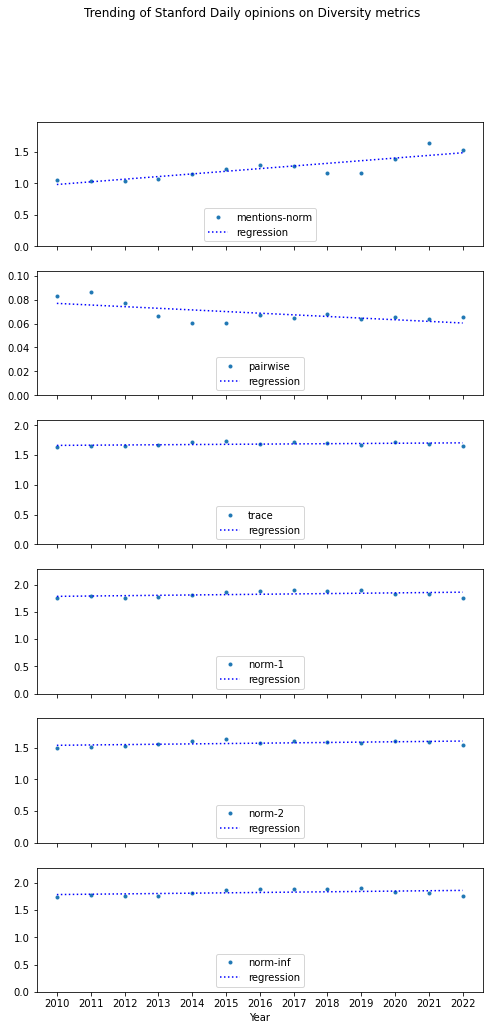

In [ ]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8,16))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Stanford Daily")
    
plt.xlabel("Year")
plt.suptitle("Trending of Stanford Daily opinions on Diversity metrics")
plt.show()

## Graphs for our paper writeup

NameError: name 'results_df' is not defined

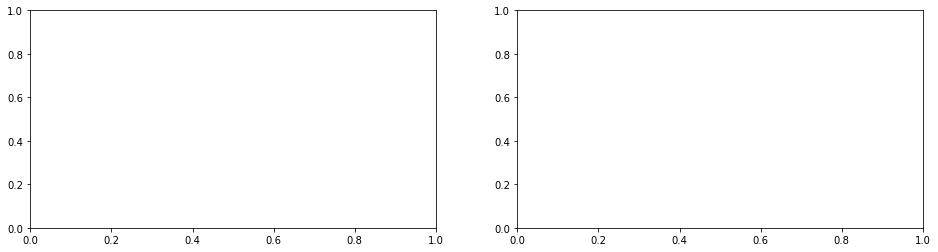

In [ ]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Stanford Daily")
    
plt.xlabel("Year")
plt.suptitle("Trending of The Stanford Daily's Opinions on Diversity metrics")
plt.show()